# Classify data w/ Keras
https://keras.io/examples/nlp/text_classification_with_transformer/

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
# load pre-processed data
train_df, test_df, test_df_truncated, solution_df_truncated, desired_class, desired_ID, no1, no2 = pickle.load( open( "cleaned_train.pkl", "rb" ) )
# text_train_arrays, text_test_arrays = pickle.load( open( "cleaned_test_bag_words.pkl", "rb" ) )
text_train_arrays_non_runcated, text_train_arrays, text_test_arrays = pickle.load( open( "cleaned_test_tfidf.pkl", "rb" ) )



In [3]:
print('X_train shape:', text_train_arrays.shape)
print('X_test shape:', text_test_arrays.shape)
print('X_train shape:', no1.shape)
print('X_train shape:', no2.shape)


X_train shape: (3316, 300)
X_test shape: (492, 300)
X_train shape: (3316, 300)
X_train shape: (492, 300)


In [4]:
# 1. Transform categorical labels to numerical labels between 0 and len(labels) using labelEncoder
# 2. one hot encode our label
y_train = train_df.Class
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_hot = np_utils.to_categorical(label_encoder.transform(y_train))

# target labels
y_true = [int(x) for x in desired_class.ravel()]
y_true_oh = solution_df_truncated.values


In [5]:
# quick visualization w/ tSNE
# we should have no problem using 300 dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(text_train_arrays)

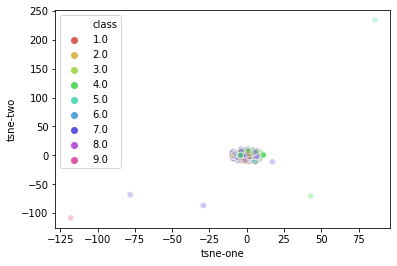

In [6]:
from mpl_toolkits.mplot3d import Axes3D

df_viz = pd.DataFrame()
df_viz['tsne-one'] = tsne_pca_results[:,0]
df_viz['tsne-two'] = tsne_pca_results[:,1]
df_viz['class'] = train_df['Class']
sns.scatterplot(x="tsne-one", y="tsne-two",
                hue="class",
                palette=sns.color_palette("hls", 9),
                data=df_viz,
                legend="full",
                alpha=0.3)
plt.show()

In [7]:
tsne_pca_results.shape

(3316, 3)

The classes are not at all well-separated! I would not expect our performance to be high, no matter what model we use

## A simple model

In [8]:
Text_INPUT_DIM=300

def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(9, activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = baseline_model()

In [9]:
estimator=model.fit(text_train_arrays, y_train_hot, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
42/42 [==============================] - 1s 16ms/step - loss: 2.1127 - accuracy: 0.2151 - val_loss: 1.9674 - val_accuracy: 0.3765
Epoch 2/30
42/42 [==============================] - 0s 4ms/step - loss: 1.8390 - accuracy: 0.2893 - val_loss: 1.9468 - val_accuracy: 0.3765
Epoch 3/30
42/42 [==============================] - 0s 4ms/step - loss: 1.8096 - accuracy: 0.3102 - val_loss: 1.8873 - val_accuracy: 0.3765
Epoch 4/30
42/42 [==============================] - 0s 3ms/step - loss: 1.7801 - accuracy: 0.3359 - val_loss: 1.8751 - val_accuracy: 0.3810
Epoch 5/30
42/42 [==============================] - 0s 3ms/step - loss: 1.7476 - accuracy: 0.3845 - val_loss: 1.8253 - val_accuracy: 0.3780
Epoch 6/30
42/42 [==============================] - 0s 4ms/step - loss: 1.6916 - accuracy: 0.4074 - val_loss: 1.7539 - val_accuracy: 0.3810
Epoch 7/30
42/42 [==============================] - 0s 4ms/step - loss: 1.6060 - accuracy: 0.4287 - val_loss: 1.7098 - val_accuracy: 0.3343
Epoch 8/30
42/42 [=

In [10]:
estimator.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [11]:
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

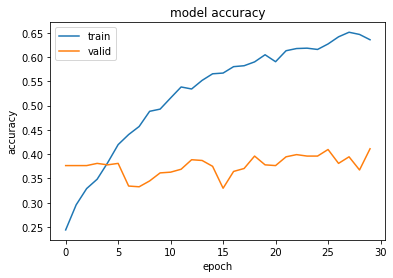

In [12]:
plot_accuracy(estimator)

In [13]:
def pred_and_decode(model, x_test):
    y_pred_prob = model.predict(x_test)
    y_pred_k1 = y_pred_prob.argmax(axis=-1)
    y_pred = label_encoder.inverse_transform(y_pred_k1)
    
    #pred_class = y_pred_k1
    #pred_class_df = pd.DataFrame({'ID':pred_ID, 'pred_class':pred_class})
    #merged_class_df = pd.merge(pred_class_df,desired_class_df,on='ID')
    #y_pred = merged_class_df.pred_class
    #y_true = merged_class_df.desired_class

    return list(y_pred),y_pred_prob

In [14]:
def assess_results(y_true,y_pred):
    # build confusion matrix
    confusion = pd.crosstab(pd.Series(y_true),pd.Series(y_pred),margins = False)
    sns.heatmap(confusion,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Desired')
    plt.show()
    
    print(classification_report(y_true,y_pred))
    print('MCC:', matthews_corrcoef(y_true,y_pred))
    

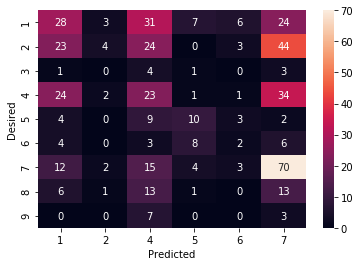

              precision    recall  f1-score   support

           1       0.27      0.28      0.28        99
           2       0.33      0.04      0.07        98
           3       0.00      0.00      0.00         9
           4       0.18      0.27      0.21        85
           5       0.31      0.36      0.33        28
           6       0.11      0.09      0.10        23
           7       0.35      0.66      0.46       106
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00        10

    accuracy                           0.28       492
   macro avg       0.17      0.19      0.16       492
weighted avg       0.25      0.28      0.23       492

MCC: 0.12156815841451994


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[3.8853846e-03, 1.4666288e-01, 1.2992247e-02, ..., 8.1085247e-01,
        2.1004970e-03, 2.1585254e-03],
       [4.0380073e-01, 1.7205669e-02, 4.6658196e-02, ..., 2.6709650e-02,
        1.1725535e-02, 2.2249255e-02],
       [1.7011094e-01, 1.8249045e-01, 2.2923207e-02, ..., 4.3856943e-01,
        1.0008283e-02, 1.2846805e-02],
       ...,
       [1.1066997e-02, 3.8818210e-02, 1.4169022e-01, ..., 3.5700765e-01,
        8.4441509e-03, 2.5090594e-02],
       [3.4636045e-01, 4.4764346e-03, 2.8453420e-03, ..., 1.1307766e-03,
        1.2381279e-03, 1.1267248e-03],
       [5.7486480e-01, 5.0515035e-04, 3.4331589e-03, ..., 4.8944185e-04,
        7.7927025e-04, 9.5200370e-04]], dtype=float32)

In [15]:
# assess results
y_pred,y_pred_prob = pred_and_decode(model, text_test_arrays)
assess_results(y_true,y_pred)
model.predict(text_test_arrays)

This baseline model's validation accuracy is pretty bad, but its MCC and weighted-f1 score average are moderately better than Doc2Vec alone. Let's include gene and variation data into the training data.

### ROC curves
Build ROC curves in a one-vs-all manner

In [16]:
# make ROC with these variables
print('model prediction output:', y_pred_prob.shape)
print('target label output:', y_true_oh.shape)

model prediction output: (492, 9)
target label output: (492, 9)


In [17]:
# put everything together into a function
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true,y_pred,title='ROC title',num_classes=9):
    # calculate ROC in a one-vs-all manner
    # y_true needs to be binary (one-hot encoded)
    # y_pred needs to be probabilities
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i],y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot of a ROC curve for a specific class
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label='Class %i (area = %0.2f)' %(i+1,roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

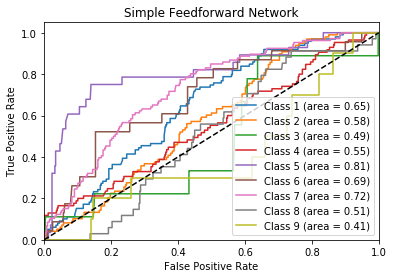

In [18]:
roc_simple_feedforward = plot_roc(y_true_oh,model.predict(text_test_arrays),'Simple Feedforward Network')

## Using Gene & Variation data

In [19]:
from sklearn.decomposition import TruncatedSVD

Gene_INPUT_DIM=25
svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

# one-hot encode Gene and Variation Data
gene_hot_train = pd.get_dummies(train_df['Gene'])
truncated_gene_hot_train = svd.fit_transform(gene_hot_train.values)
var_hot_train = pd.get_dummies(train_df['Variation'])
truncated_var_hot_train = svd.fit_transform(var_hot_train.values)

gene_hot_test = pd.get_dummies(test_df_truncated['Gene'])
truncated_gene_hot_test = svd.fit_transform(gene_hot_test.values)
var_hot_test = pd.get_dummies(test_df_truncated['Variation'])
truncated_var_hot_test = svd.fit_transform(var_hot_test.values)

In [20]:
# combine Gene, Variation into encoded paragraph vectors array
X_train=np.hstack((truncated_gene_hot_train,truncated_var_hot_train,text_train_arrays))
X_test=np.hstack((truncated_gene_hot_test,truncated_var_hot_test,text_test_arrays))

In [21]:
# train the model once more
Text_INPUT_DIM=300

def baseline_model_big():
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+Gene_INPUT_DIM*2, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(9, activation="softmax"))
    
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model_big = baseline_model_big()

In [22]:
model_big.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               89856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 729       
Total params: 176,937
Trainable params: 176,937
Non-trainable params: 0
________________________________________________

In [23]:
estimator2=model_big.fit(X_train, y_train_hot, validation_split=0.2, epochs=30, batch_size=64)

Epoch 1/30
42/42 [==============================] - 1s 7ms/step - loss: 2.0983 - accuracy: 0.2497 - val_loss: 2.0028 - val_accuracy: 0.1943
Epoch 2/30
42/42 [==============================] - 0s 4ms/step - loss: 1.8262 - accuracy: 0.3199 - val_loss: 1.9342 - val_accuracy: 0.3735
Epoch 3/30
42/42 [==============================] - 0s 5ms/step - loss: 1.7426 - accuracy: 0.3572 - val_loss: 1.8893 - val_accuracy: 0.3599
Epoch 4/30
42/42 [==============================] - 0s 4ms/step - loss: 1.6937 - accuracy: 0.3971 - val_loss: 1.8437 - val_accuracy: 0.3855
Epoch 5/30
42/42 [==============================] - 0s 4ms/step - loss: 1.5992 - accuracy: 0.4250 - val_loss: 1.7459 - val_accuracy: 0.3931
Epoch 6/30
42/42 [==============================] - 0s 6ms/step - loss: 1.4990 - accuracy: 0.4678 - val_loss: 1.7930 - val_accuracy: 0.3178
Epoch 7/30
42/42 [==============================] - 0s 4ms/step - loss: 1.4108 - accuracy: 0.5006 - val_loss: 1.6495 - val_accuracy: 0.3855
Epoch 8/30
42/42 [==

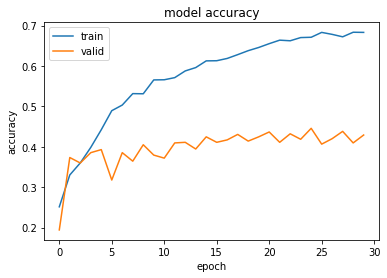

In [24]:
plot_accuracy(estimator2)

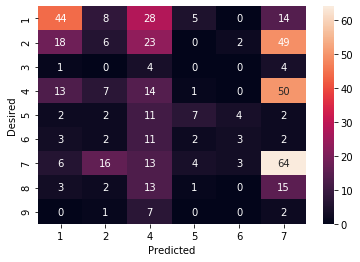

              precision    recall  f1-score   support

           1       0.49      0.44      0.47        99
           2       0.14      0.06      0.08        98
           3       0.00      0.00      0.00         9
           4       0.11      0.16      0.13        85
           5       0.35      0.25      0.29        28
           6       0.25      0.13      0.17        23
           7       0.32      0.60      0.42       106
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00        10

    accuracy                           0.28       492
   macro avg       0.18      0.18      0.17       492
weighted avg       0.24      0.28      0.25       492

MCC: 0.11643438016431354


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
y_pred,y_pred_prob = pred_and_decode(model_big, X_test)
assess_results(y_true,y_pred)

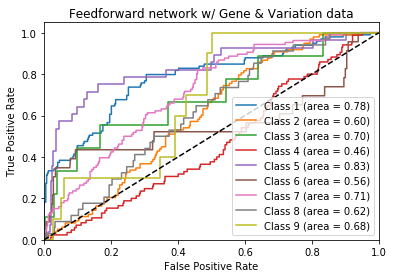

In [26]:
roc_simple_gene_var = plot_roc(y_true_oh,y_pred_prob,'Feedforward network w/ Gene & Variation data')

The validation results seem equally bad, but the MCC and weighted f1 score seems to have improved marginally.

## Doc2Vec -> LSTMs
(inspiration: https://www.kaggle.com/viveksinghub/lstm-with-doc2vec)

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [28]:
# Build out our simple LSTM
# I'm skipping the embedding layer because we already created word vectors from Dov2Vec
embed_dim = 128
lstm_out = 196
num_words = 2000

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_lstm_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

def lstm_model(c,training_weights):
    model = Sequential()
    #model.add(Embedding(num_words,embed_dim,input_length=c))
    model.add(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.2, dropout=0.2, input_shape=(1,c)))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(9,activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy','accuracy'])
    
    return model
    
model_lstm = lstm_model(X_train.shape[1],X_train)
print(model_lstm.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 196)            428848    
_________________________________________________________________
dense_8 (Dense)              (None, 1, 30)             5910      
_________________________________________________________________
dense_9 (Dense)              (None, 1, 9)              279       
Total params: 435,037
Trainable params: 435,037
Non-trainable params: 0
_________________________________________________________________
None


 not sure why there must be an extra dimension...

In [29]:
print(X_train.shape)
print(y_train_hot.shape)
print(train_df.shape)
y_train_hot

(3316, 350)
(3316, 9)
(3316, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train_rs = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
y_train_rs = np.reshape(y_train_hot, (y_train_hot.shape[0],1,y_train_hot.shape[1]))
X_train_rs.shape

(3316, 1, 350)

In [31]:
history_lstm = model_lstm.fit(X_train_rs,y_train_rs, validation_split=0.2, epochs=20)

Epoch 1/20
83/83 [==============================] - 3s 10ms/step - loss: 2.1187 - categorical_crossentropy: 2.1187 - accuracy: 0.3020 - val_loss: 1.9631 - val_categorical_crossentropy: 1.9631 - val_accuracy: 0.1024
Epoch 2/20
83/83 [==============================] - 0s 5ms/step - loss: 1.4987 - categorical_crossentropy: 1.4987 - accuracy: 0.5120 - val_loss: 1.6827 - val_categorical_crossentropy: 1.6827 - val_accuracy: 0.3720
Epoch 3/20
83/83 [==============================] - 0s 5ms/step - loss: 1.1792 - categorical_crossentropy: 1.1792 - accuracy: 0.5893 - val_loss: 1.5780 - val_categorical_crossentropy: 1.5780 - val_accuracy: 0.3825
Epoch 4/20
83/83 [==============================] - 0s 6ms/step - loss: 1.0403 - categorical_crossentropy: 1.0403 - accuracy: 0.6416 - val_loss: 1.6386 - val_categorical_crossentropy: 1.6386 - val_accuracy: 0.3373
Epoch 5/20
83/83 [==============================] - 0s 6ms/step - loss: 1.0286 - categorical_crossentropy: 1.0286 - accuracy: 0.6325 - val_loss

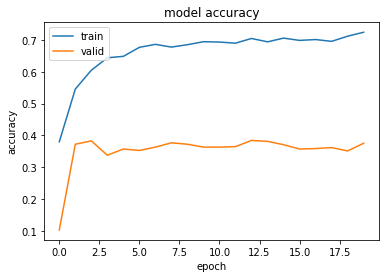

In [32]:
plot_accuracy(history_lstm)

C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


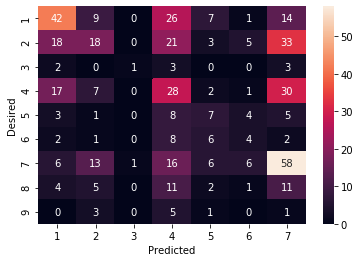

              precision    recall  f1-score   support

           1       0.45      0.42      0.44        99
           2       0.32      0.18      0.23        98
           3       0.50      0.11      0.18         9
           4       0.22      0.33      0.27        85
           5       0.21      0.25      0.23        28
           6       0.18      0.17      0.18        23
           7       0.37      0.55      0.44       106
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00        10

    accuracy                           0.32       492
   macro avg       0.25      0.22      0.22       492
weighted avg       0.30      0.32      0.30       492

MCC: 0.17483752099463892


C:\Users\Kenny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
X_test_rs = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))

y_pred,y_pred_prob = pred_and_decode(model_lstm, X_test_rs)
assess_results(y_true,y_pred)

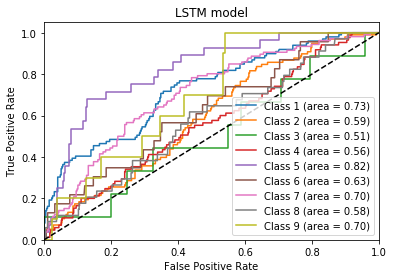

In [34]:
roc_lstm1 = plot_roc(y_true_oh,y_pred_prob.squeeze(),'LSTM model')

In [35]:
aucs = {'simple':list(roc_simple_feedforward.values()),
        'simple_gene_var':list(roc_simple_gene_var.values()),
        'lstm':list(roc_lstm1.values())}
pd.DataFrame(aucs)

,simple,simple_gene_var,lstm
0,0.650269,0.782905,0.727491
1,0.580636,0.603142,0.592678
2,0.494249,0.697493,0.514148
3,0.554459,0.463897,0.563275
4,0.811615,0.826817,0.822506
5,0.689117,0.560814,0.625892
6,0.722382,0.713474,0.704064
7,0.508766,0.619863,0.577543
8,0.409544,0.683402,0.696888


Other things to note:
* An example of [Multi-class text classification in Keras](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17) classifying consumer reports into the topics of complaint is a good reference

1. Define functions
2. define y_true
3. Text clean up & vectorization - both train & test
4. run model #1 (logistic classifer) on X_train, X_test, y_train, y_test
5. run model #2 (random forest) on X_train, X_test, y_train, y_test